# Riemannian Brownian Mixture Model

In [2]:
#Modules

#jax
from jax import jacfwd, vmap, lax
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

#numpy
import numpy as np

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

from scipy.io import loadmat

#scores
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import diffusion_mean as dm_score
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.statistics.score_matching import BrownianMixtureGrad, BrownianMixtureEM
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
2024-05-15 01:00:04.510405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
#Hyper Parameters
T = 0.5
t0 = 0.01
score_path = "scores"
s2_approx = 0
s1loss_type = "dsm"
s2loss_type = "dsm"
s2_type = "s1s2"
seed = 2712
K = 4

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [4]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}_{s2loss_type}/"))
    layers_s1, layers_s2 = get_generator_dim(manifold, generator_dim)

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers_s1)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers_s2, layers_beta=layers_s2,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers_s1), 
                    models.MLP_s2(layers_alpha=layers_s2, 
                                  layers_beta=layers_s2,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval

In [5]:
def load_heat_model(manifold, dim, method="Local"):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1p_path = ''.join((score_path, f"/{manifold}{dim}/s1p_{s1loss_type}/"))
    layers = get_generator_dim(manifold, generator_dim)[0]

    s1p_model = hk.transform(lambda x: models.MLP_p(dim=generator_dim, layers=layers)(x))
        
    s1p_state = model_loader.load_model(s1p_path)
    
    rng_key = jrandom.PRNGKey(seed)
    
    if method == "Local":
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((x[0],y[0],t)))
    else:
        s1p_fun = lambda x,y,t: s1p_model.apply(s1p_state.params, rng_key, jnp.hstack((M.F(x),M.F(y),t)))
                       
    return s1p_fun

## Testing with $\mathbb{R}^{2}$

In [5]:
M, x0, ScoreEval = load_score_model("Euclidean", 2)
s1p_fun = load_heat_model("Euclidean", 2)

using M.Exp for Logarithm
using M.Exp for Logarithm


### Generate Test Data

In [6]:
std = 0.1
x = []
centers = [jnp.array([-1.0,0.0]), jnp.array([0.0,1.0]), jnp.array([1.0,0.0]), jnp.array([0.0,-1.0])]
for i in range(K):
    eps = std*np.random.normal(size=(100,2))
    x.append(eps+centers[i])
x = jnp.vstack(x)

X_obs = (x, jnp.zeros(len(x)).reshape(-1))

### Testing with True Gradient

In [7]:
RBMM = BrownianMixtureGrad(M=M,
                           log_hk = M.log_hk, #s1p_fun
                           grady_log=lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                           gradt_log=M.gradt_log_hk,
                           n_clusters=4,
                           eps=0.1,
                           method='Local',
                           update_method="Gradient",
                           warmup=100,
                           max_iter=1000,
                           lr=0.1,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                          )

In [8]:
RBMM = BrownianMixtureEM(M=M,
                           log_hk = M.log_hk, #s1p_fun
                           grady_log=lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                           gradt_log=M.gradt_log_hk,
                           n_clusters=4,
                           eps=0.1,
                           method='Local',
                           update_method="Gradient",
                           grad_iter=100,
                           em_iter=100,
                           lr=0.1,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                          )

In [9]:
RBMM.fit((X_obs[0], X_obs[1].reshape(-1,1)))

In [10]:
T = RBMM.T
mu = RBMM.mu
gradt_log = vmap(lambda x,c: vmap(lambda mu_x, mu_c, t: M.gradt_log_hk((x,c),
                                                                       (mu_x, mu_c),
                                                                       t))(mu[0],
                                                                           mu[1],
                                                                           T))(X_obs[0],
                                                                               X_obs[1])

In [11]:
clusters = RBMM.classify(X_obs)

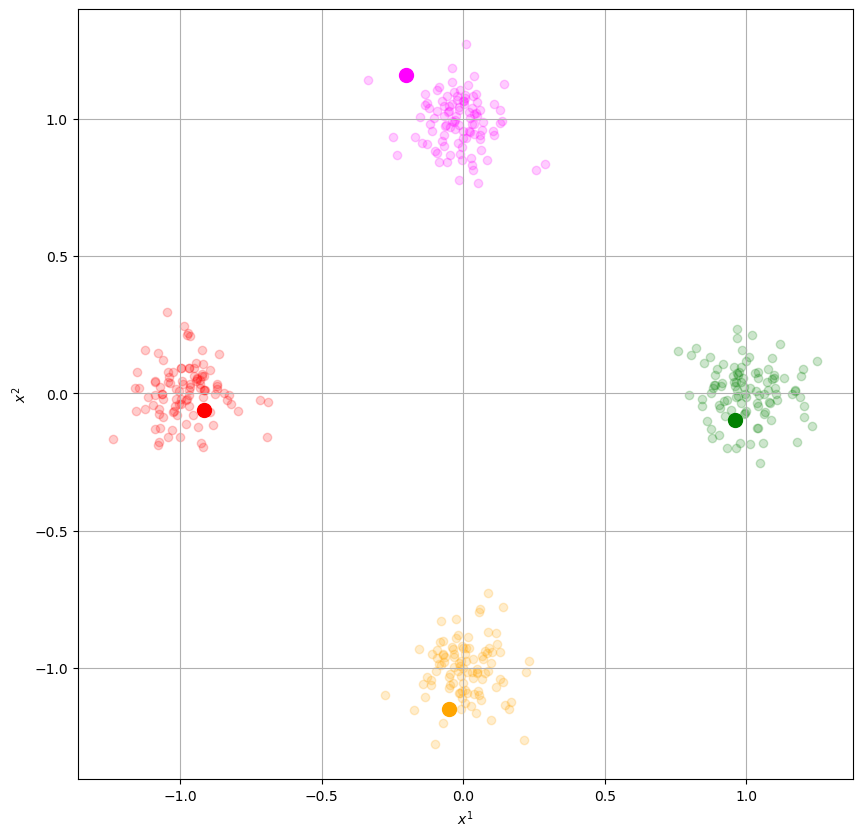

In [12]:
color = ['magenta', 'red', 'green', 'orange']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(K):
    ax.scatter(RBMM.mu[0][i,0], RBMM.mu[0][i,1], alpha=1.0, s=100, color=color[i])
    
for i in range(len(X_obs[0])):
    ax.scatter(X_obs[0][i,0], 
               X_obs[0][i,1], alpha=0.2, color=color[clusters[i]], label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

### Testing with Learned Gradient

In [13]:
RBMM = BrownianMixtureEM(M=M,
                           log_hk = s1p_fun, #s1p_fun
                           grady_log=ScoreEval.grady_log,
                           gradt_log=ScoreEval.gradt_log,
                           n_clusters=4,
                           eps=0.1,
                           method='Local',
                           update_method="Gradient",
                           grad_iter=100,
                           em_iter=100,
                           lr=0.1,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                          )
#RBMM = BrownianMixtureGrad(M=M,
#                           log_hk = lambda x,y,t: lax.stop_gradient(s1p_fun(x,y,t)), #s1p_fun
#                           grady_log=lambda x,y,t: lax.stop_gradient(ScoreEval.grady_log(x,y,t)),
#                           gradt_log=lambda x,y,t: lax.stop_gradient(ScoreEval.gradt_log(x,y,t)),
#                           n_clusters=4,
#                           eps=0.1,
#                           method='Local',
#                           update_method="Gradient",
#                           warmup=10,
#                           max_iter=1000,
#                           lr=0.01,
#                           dt_steps=100,
#                           min_t=1e-2,
#                           max_t=1.0,
#                           seed=2712,
#                          )

In [14]:
RBMM.fit((X_obs[0], X_obs[1].reshape(-1,1)))

In [15]:
T = RBMM.T
mu = RBMM.mu
gradt_log = vmap(lambda x,c: vmap(lambda mu_x, mu_c, t: M.gradt_log_hk((x,c),
                                                                       (mu_x, mu_c),
                                                                       t))(mu[0],
                                                                           mu[1],
                                                                           T))(X_obs[0],
                                                                               X_obs[1])

In [16]:
clusters = RBMM.classify(X_obs)

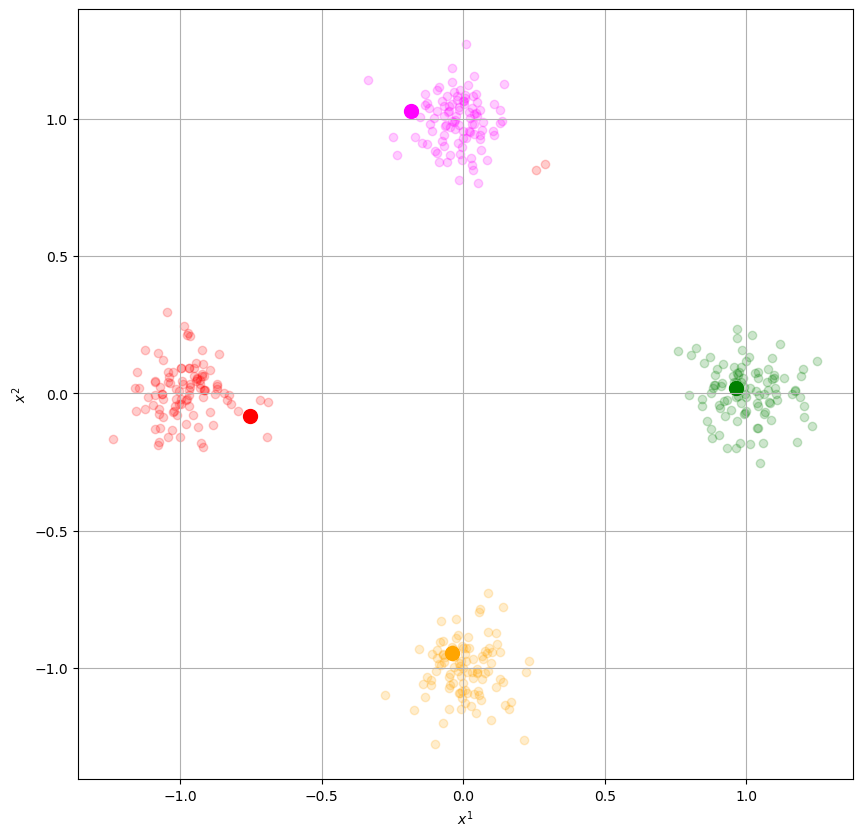

In [17]:
color = ['magenta', 'red', 'green', 'orange']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(K):
    ax.scatter(RBMM.mu[0][i,0], RBMM.mu[0][i,1], alpha=1.0, s=100, color=color[i])
    
for i in range(len(X_obs[0])):
    ax.scatter(X_obs[0][i,0], 
               X_obs[0][i,1], alpha=0.2, color=color[clusters[i]], label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

## Application to $\mathbb{S}^{2}$ data

In [6]:
M, x0, ScoreEval = load_score_model("Sphere", 2)
s1p_fun = load_heat_model("Sphere", 2)

using M.Exp for Logarithm
using M.Exp for Logarithm


In [6]:
sphere_data = loadmat('../../../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
Xsphere_obs = vmap(lambda chart: ScoreEval.update_coords(chart))(charts)

In [7]:
import pandas as pd

data = pd.read_csv('../../../Data/S2/transits.csv', sep='%')
data[['phi','theta']] = data['Unnamed: 0'].str.split(',',expand=True)
data['phi'] = data['phi'].astype('float')
data['theta'] = data['theta'].astype('float')

phi = jnp.array(data['phi'])
theta = jnp.array(data['theta'])

charts = jnp.array([jnp.cos(phi)*jnp.sin(theta),
                   jnp.sin(phi)*jnp.sin(theta),
                   jnp.cos(theta)]).T

charts = charts[charts[:,2]<0.]

Xsphere_obs = vmap(lambda chart: ScoreEval.update_coords(chart))(charts)


In [64]:
import pandas as pd

data = pd.read_csv('../../../Data/S2/image_data.csv', sep=',')

Xsphere_obs = vmap(lambda chart: ScoreEval.update_coords(chart))(charts)


In [8]:
# Creating the theta and phi values.
intervals = 100
ntheta = intervals
nphi = 2*intervals

theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)

# Creating the coordinate grid for the unit sphere.
X1_S2 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2_S2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3_S2 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X_heat = jnp.transpose(jnp.concatenate((X1_S2.reshape(1, ntheta+1, nphi+1), 
                     X2_S2.reshape(1, ntheta+1, nphi+1), 
                     X3_S2.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))

grid_points = vmap(lambda x1: ScoreEval.update_coords(x1))(X_heat.reshape(-1,3))
    

In [9]:
RBMM = BrownianMixtureGrad(M=M,
                           log_hk = lambda x,y,t: lax.stop_gradient(s1p_fun(x,y,t)), #s1p_fun
                           grady_log=lambda x,y,t: lax.stop_gradient(ScoreEval.grady_log(x,y,t)),
                           gradt_log=lambda x,y,t: lax.stop_gradient(ScoreEval.gradt_log(x,y,t)),
                           n_clusters=4,
                           eps=0.1,
                           method='Embedded',
                           update_method="Gradient",
                           warmup=0,
                           max_iter=1000,
                           lr=0.1,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                           grid_points = grid_points,
                          )

In [21]:
RBMM = BrownianMixtureEM(M=M,
                           log_hk = lambda x,y,t: lax.stop_gradient(s1p_fun(x,y,t)),#M.log_hk, #s1p_fun
                           grady_log=lambda x,y,t: lax.stop_gradient(ScoreEval.grady_log(x,y,t)),#lambda x,y,t: M.grady_log_hk(x,y,t)[0],
                           gradt_log=lambda x,y,t: lax.stop_gradient(ScoreEval.gradt_log(x,y,t)),#M.gradt_log_hk,
                           n_clusters=4,
                           eps=0.1,
                           method='Local',
                           update_method="Gradient",
                           grad_iter=1,
                           em_iter=1000,
                           lr=0.01,
                           dt_steps=100,
                           min_t=1e-2,
                           max_t=1.0,
                           seed=2712,
                            grid_points = grid_points,
                          )

In [ ]:
test = RBMM.fit((Xsphere_obs[0][::10], Xsphere_obs[1][::10]))

In [17]:
T = RBMM.T
mu = RBMM.mu

In [18]:
RBMM.pi(RBMM.alpha)

AttributeError: 'BrownianMixtureEM' object has no attribute 'alpha'

In [19]:
mu

(Array([[-1.4901161e-08,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00]], dtype=float32),
 Array([[-0.84020585,  0.4614001 , -0.28489342],
        [-0.6520574 , -0.7552019 , -0.06701601],
        [-0.4854985 , -0.6663531 , -0.5659194 ],
        [-0.6520574 , -0.7552019 , -0.06701601]], dtype=float32))

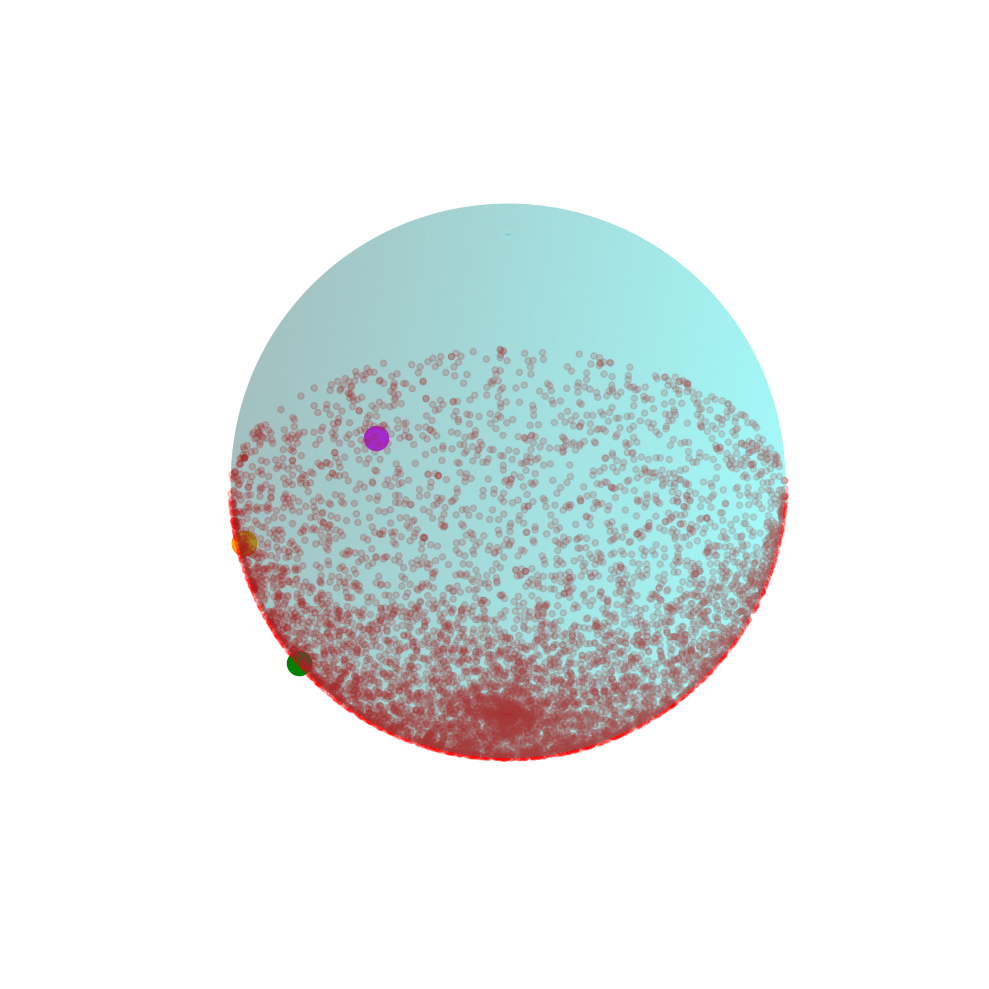

In [20]:
color = ['magenta', 'red', 'green', 'orange', "blue"]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
ax.scatter(Xsphere_obs[1][:,0], Xsphere_obs[1][:,1], Xsphere_obs[1][:,2], color='red', alpha=0.2)
#ax.scatter(centroidssm_s2[1][:,0], centroidssm_s2[1][:,1], centroidssm_s2[1][:,2], color='blue', alpha=1.0, s=300, label='Centroids')
j = 0
for center in RBMM.mu[1]:
    ax.scatter(center[0], center[1], center[2], color=color[j], alpha=1.0, s=300, label='Centroids')
    j += 1

#for i in range(len(centroidsm_idxs_s2)):
#    ax.scatter(X_obs[1][centroidsm_idxs_s2[i],0], 
#               X_obs[1][centroidsm_idxs_s2[i],1], 
#               X_obs[1][centroidsm_idxs_s2[i],2], alpha=0.5, s=100, color=color[i], label='Cluser ' + str(i+1))

#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
#ax.view_init(elev=90, azim=270)
fig.tight_layout()

In [142]:
diffusion_mean(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [143]:
musphere_sm, Tsphere_sm, _, _ = M.sm_dmxt(Xsphere_obs, (Xsphere_obs[0][0], Xsphere_obs[1][0]), jnp.array([0.2]), 
                                         step_size=0.1, max_iter=1000)

In [144]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
musphere_opt, Tsphere_opt, _, _ = M.sm_dmxt(Xsphere_obs, (Xsphere_obs[0][0], Xsphere_obs[1][0]), jnp.array([0.1]))

In [145]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [146]:
file_path = 'scores/S2/s1_dsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [147]:
from scipy.io import loadmat

sphere_data = loadmat('../../../../../Data/sphere_walking/sphere_walking.mat', squeeze_me=True)
charts = jnp.array(sphere_data['data']).T
X_obs = vmap(lambda chart: get_coords(S2, chart))(charts)
Xobs_s2 = X_obs

In [148]:
import pandas as pd
N = 1000

data = pd.read_csv('../../../../../Data/S2/image_data.csv', sep=',')
data = jnp.array(data)
idx = np.round(np.linspace(0, len(data) - 1, N)).astype(int)
data = data[idx]
X_obs = vmap(lambda chart: get_coords(M, chart))(jnp.array(data))


In [149]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])
dist_fun = lambda x,y,t=0.1: jnp.arccos(jnp.dot(x[1],y[1]))

In [150]:
diffusion_mean(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

#def frechet_fun(X_obs, X_init, t=0.1):
    
#    mu = S2.sm_dmx(X_obs, X_init, t, step_size=0.1, max_iter=100)[0]
    
#    return (mu[0][-1], mu[1][-1])

def frechet_fun(X_obs, X_init, t=0.1):
    
    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [151]:
from jaxgeometry.statistics.score_matching import kmeans

In [152]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=5, max_iter = 100)

In [153]:
RMK.fit(X_obs) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

AttributeError: module 'random' has no attribute 'split'

In [406]:
centroidseuc_s2, centroideuc_idxs_s2 = RMK.centroids, RMK.centroid_idx

In [407]:
S2 = nSphere(N=2)
jstoch.Brownian_coords(S2)
jstat.diffusion_mean(S2)
S2_x0 = S2.coords([0.]*2)

using M.Exp for Logarithm


In [408]:
file_path = 'scores/S2/vsm/'
s2_state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1_s2 = hk.transform(lambda x: models.MLP_s1(dim=S2.emb_dim, layers=layers)(x))
s2_s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=S2.emb_dim, r = max(S2.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t))))

def gradt_log(x,y,t):
    
    grad_val = grady_log_s2(x, y, t)
            
    return 0.5*(jnp.dot(grad_val, grad_val)+M.div(y,lambda y: grady_log_s2(x, y, t)))

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: to_TMx(S2, y[1], s1_s2.apply(s2_state.params,rng_key, jnp.hstack((x[1], y[1], t)))))(y)
    
    return ggrad

In [409]:
#dist_fun = lambda x,y,t=0.1: jnp.sqrt(-S2.transition_density(x,y,jnp.array([t]), N=1)*t*2)
dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(t*grady_log(x,y,t))
#dist_fun = lambda x,y,t=0.1: jnp.linalg.norm(x[1]-y[1])

In [410]:
diffusion_mean.initialize(S2, s1_model=lambda x,y,t: t*grady_log(x,y,t), s2_model = gradt_log, method="Gradient")

def frechet_fun(X_obs, X_init, t=0.1):
    
    mu = S2.sm_dmx(X_obs, X_init, t, step_size=0.01, max_iter=100)[0]
    
    return (mu[0][-1], mu[1][-1])

#def frechet_fun(X_obs, X_init, t=0.01):
    
#    return (S2.invF((X_init[1], jnp.mean(X_obs[1], axis=0))), jnp.mean(X_obs[1], axis=0))

In [411]:
from jaxgeometry.statistics.score_matching import kmeans

In [412]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=5, max_iter = 100)

In [413]:
RMK.fit(X_obs) #centroids=(X_obs[0][jnp.array([0,20,30,40])], X_obs[1][jnp.array([0,20,30,40])]))

Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iterat

In [414]:
centroidssm_s2, centroidsm_idxs_s2 = RMK.centroids, RMK.centroid_idx

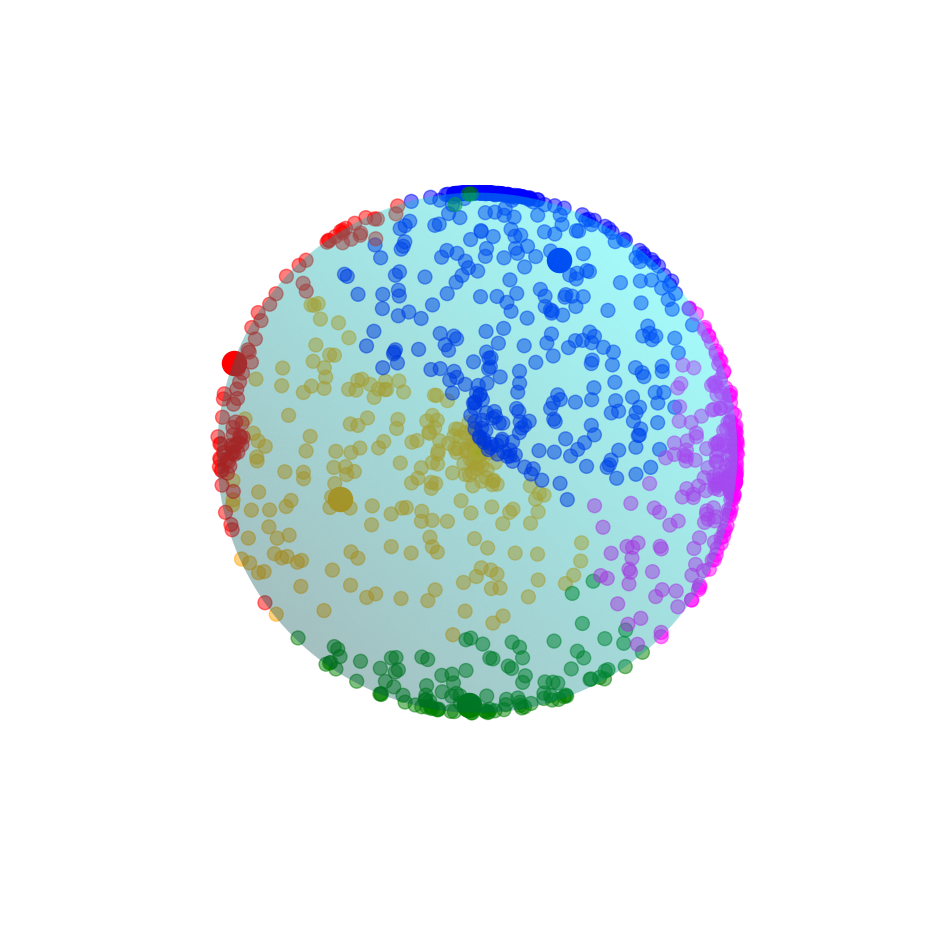

In [415]:
color = ['magenta', 'red', 'green', 'orange', "blue"]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
intervals = 100
ntheta = intervals
nphi = 2*intervals
theta = jnp.linspace(0.0, jnp.pi*1, ntheta+1)
phi   = jnp.linspace(0.0, jnp.pi*2, nphi+1)
# Creating the coordinate grid for the unit sphere.
X1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
X2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
X3 = jnp.outer(jnp.cos(theta), jnp.ones(nphi+1))
X = jnp.transpose(jnp.concatenate((X1.reshape(1, ntheta+1, nphi+1), 
                     X2.reshape(1, ntheta+1, nphi+1), 
                     X3.reshape(1, ntheta+1, nphi+1))), axes=(1,2,0))
ax.plot_surface(X1, X2, X3, rstride=1, cstride=1, color='cyan', alpha=0.2)
#ax.scatter(centroidssm_s2[1][:,0], centroidssm_s2[1][:,1], centroidssm_s2[1][:,2], color='blue', alpha=1.0, s=300, label='Centroids')
j = 0
for center in centroidssm_s2[1]:
    ax.scatter(center[0], center[1], center[2], color=color[j], alpha=1.0, s=300, label='Centroids')
    j += 1

for i in range(len(centroidsm_idxs_s2)):
    ax.scatter(X_obs[1][centroidsm_idxs_s2[i],0], 
               X_obs[1][centroidsm_idxs_s2[i],1], 
               X_obs[1][centroidsm_idxs_s2[i],2], alpha=0.5, s=100, color=color[i], label='Cluser ' + str(i+1))

#ax.scatter(X_obs[1][0,0], X_obs[1][0,1], X_obs[1][0,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][20,0], X_obs[1][20,1], X_obs[1][20,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][30,0], X_obs[1][30,1], X_obs[1][30,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
#ax.scatter(X_obs[1][40,0], X_obs[1][40,1], X_obs[1][40,2], color='Purple', alpha=1.0, s=500, label='Score Matching')
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=90, azim=270)
fig.tight_layout()